In [ ]:
#pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pandas_datareader.data as data
import pandas_datareader.data as web
from datetime import datetime, date, timedelta
import os.path
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

In [2]:
def get_historical(quote):
        end = datetime.now()
        start = datetime(end.year-9,end.month,end.day)
        data = yf.download(quote, start=start, end=end)
        df = pd.DataFrame(data=data)
        df.to_csv(''+quote+'.csv')
        if(df.empty):
            ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
            data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
            #Format df
            #Last 2 yrs rows => 502, in ascending order => ::-1
            data=data.head(503).iloc[::-1]
            data=data.reset_index()
            #Keep Required cols only
            df=pd.DataFrame()
            #df['Date']=data['date']
            df['Open']=data['1. open']
            df['High']=data['2. high']
            df['Low']=data['3. low']
            df['Close']=data['4. close']
            #df['Adj Close']=data['5. adjusted close']
            df['Volume']=data['6. volume']
            df.drop(['Adj Close'])
            df.to_csv(''+quote+'.csv',index=False)
            #df.drop(['Date','Adj Close'], axis =1)
        return(start,end)

In [3]:
ticker='FB'
start,end=get_historical(ticker)

[*********************100%***********************]  1 of 1 completed


In [4]:
start.date()

datetime.date(2013, 5, 31)

In [5]:
df = pd.read_csv(ticker+'.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-05-30,24.129999,24.780001,23.930000,24.549999,24.549999,60733200
1,2013-05-31,24.629999,24.950001,24.270000,24.350000,24.350000,35925000
2,2013-06-03,24.270000,24.320000,23.709999,23.850000,23.850000,35733800
3,2013-06-04,23.889999,23.930000,23.320000,23.520000,23.520000,34760800
4,2013-06-05,23.350000,23.709999,22.790001,22.900000,22.900000,53819700


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2262,2022-05-23,195.190002,196.990005,191.240005,196.229996,196.229996,25059200
2263,2022-05-24,180.550003,183.679993,176.110001,181.279999,181.279999,50406300
2264,2022-05-25,180.399994,185.449997,179.320007,183.830002,183.830002,28030200
2265,2022-05-26,182.880005,192.830002,182.259995,191.630005,191.630005,23056500
2266,2022-05-27,191.360001,195.330002,189.800003,195.130005,195.130005,22548900


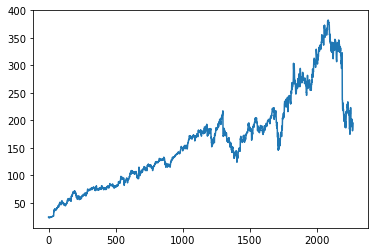

In [7]:
plt.plot(df.Close)

In [8]:
ma100=df.Close.rolling(100).mean() #created a moving average of ma100
#ma100
ma200=df.Close.rolling(200).mean() #created a moving average of ma200
#ma200

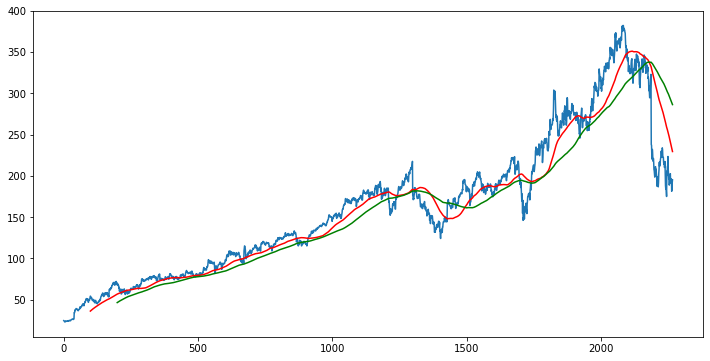

In [9]:
#plotting both moving average and the original Close
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [10]:
df.shape

(2267, 7)

In [11]:
#Splitting into Training and testing
end_limit=len(df)
limit=int(end_limit*0.7)
data_training = pd.DataFrame(df['Close'][0:limit])
data_testing =  pd.DataFrame(df['Close'][limit:end_limit])

In [12]:
#data_training.head()
#data_testing.head()
#Checking out the data

In [13]:
#LSTM model uses Data Range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
#created an Object to normalize data between the two

In [15]:
data_testing_array=scaler.fit_transform(data_testing)
data_training_array=scaler.fit_transform(data_training)
data_training_array.shape
#transforming the columns to feature range

(1586, 1)

In [16]:
x_train=[]
y_train=[]

for i in range(100,data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])
    
x_train,y_train = np.array(x_train), np.array(y_train)
#print(x_train.shape)
#print(y_train.shape)

In [17]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras

In [18]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True,
              input_shape =(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [ ]:
#model.summary()

<h2>Compiling the model</h2>

<p>Skip compiling the model over and over, use the saved model state insted</p>

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, epochs=50)

Epoch 1/50
47/47 [==============================] - 12s 181ms/step - loss: 0.0731
Epoch 2/50
47/47 [==============================] - 8s 168ms/step - loss: 0.0145
Epoch 3/50
47/47 [==============================] - 8s 167ms/step - loss: 0.0115
Epoch 4/50
47/47 [==============================] - 8s 167ms/step - loss: 0.0099
Epoch 5/50
47/47 [==============================] - 8s 174ms/step - loss: 0.0093
Epoch 6/50
47/47 [==============================] - 8s 170ms/step - loss: 0.0093
Epoch 7/50
47/47 [==============================] - 8s 170ms/step - loss: 0.0083
Epoch 8/50
47/47 [==============================] - 8s 169ms/step - loss: 0.0079
Epoch 9/50
47/47 [==============================] - 8s 169ms/step - loss: 0.0073
Epoch 10/50
47/47 [==============================] - 8s 169ms/step - loss: 0.0075
Epoch 11/50
47/47 [==============================] - 8s 172ms/step - loss: 0.0076
Epoch 12/50
47/47 [==============================] - 8s 170ms/step - loss: 0.0081
Epoch 13/50
47/47 [=====

In [20]:
model.save('keras_model.h5') #saving the model to avoid re-compiling everytime

<h1>Use the saved model instead of re-compiling it everytime</h1>

In [38]:
model=keras.models.load_model('keras_model.h5')

In [39]:
data_testing.head()

,Close
1586,188.080002
1587,188.139999
1588,190.139999
1589,189.929993
1590,186.820007


In [40]:
past_100_days=data_training.tail(100)

In [41]:
final_df=past_100_days.append(data_testing, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_18388\351597942.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df=past_100_days.append(data_testing, ignore_index=True)


In [42]:
final_df.head()

,Close
0,193.259995
1,191.490005
2,194.779999
3,193.399994
4,193.029999


In [43]:
#scaling down the testing data
input_data =scaler.fit_transform(final_df)
input_data.shape

(781, 1)

In [44]:
x_test=[] 
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])
    
    
################
#x_train=[]
#y_train=[]

#for i in range(100,data_training_array.shape[0]):
#    x_train.append(data_training_array[i-100:i])
 #   y_train.append(data_training_array[i,0])
    
#x_train,y_train = np.array(x_train), np.array(y_train)
#print(x_train.shape)
#print(y_train.shape)

In [45]:
x_test,y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(681, 100, 1)
(681,)


In [46]:
#Making Predictions
y_predicted = model.predict(x_test)

22/22 [==============================] - 2s 54ms/step


In [47]:
y_predicted.shape
#checking the shape of predicted arrays

(681, 1)

In [48]:
#the scale factor for the 
#print(scaler.scale_)
scale=scaler.scale_[0]
scale

0.004234238081691668

In [49]:
scale_factor=1/scale
y_predicted=y_predicted*scale_factor
#print(y_test)
y_test=y_test*scale_factor
#y_test

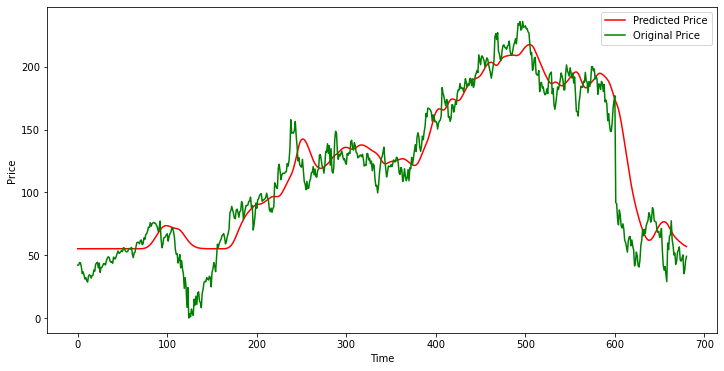

In [50]:
plt.figure(figsize=(12,6))
plt.plot(y_predicted,'r', label='Predicted Price')
plt.plot(y_test,'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

<h3>Testing out the model</h3>

In [51]:
#setting end to three days back
today = date.today()
day_before_yesterday = date.today() - timedelta(days=3)
#end

In [52]:
#end = datetime.now()
#getting data worth of last 2 years
start = datetime(end.year-2,end.month,end.day)
data = yf.download(ticker, start=start, end=day_before_yesterday)
#getting the data and filtering it upon just the Closing price of the day
data=data.filter(['Close'])

#filtering the data based upon just the last 60 days
last_60_days = data[-60:].values
#last_60_days

[*********************100%***********************]  1 of 1 completed


In [53]:
#scaling the last 60days value
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#print(last_60_days_scaled)

C:\Users\User\Desktop\Udemy\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [54]:
#scaler.scale_[0]
#last_60_days_scaled=last_60_days_scaled*(1/scaler.scale_[0])
#last_60_days_scaled=scaler.inverse_transform(last_60_days_scaled)
#last_60_days

In [60]:
#Get the predicted scaled price
pred_price = model.predict(X_test)#getting the original price
pred_price = scaler.inverse_transform(pred_price)
print(pred_price[0][0])

1/1 [==============================] - 0s 29ms/step
202.58127


In [57]:
#setting end to two days back
today = date.today()
day_before_yesterday = date.today() - timedelta(days=2)
#end
#Yesterdays actual price
yesterday = date.today() - timedelta(days=1)

In [66]:
 
data = yf.download(ticker, start=day_before_yesterday, end=yesterday)
data["Close"][0]

#data=data.filter(['Close'])
#print(data['Close'])

[*********************100%***********************]  1 of 1 completed


195.1300048828125

KeyError: 0